Приводим базовый датасет к виду который СОСО принимает(тренировочные данные)

In [ ]:
from pycocotools.coco import COCO
import os

def convert_coco_to_yolo(json_path, output_dir):
    coco = COCO(json_path)
    os.makedirs(output_dir, exist_ok=True)

    for img_id in coco.imgs:
        img_info = coco.loadImgs(img_id)[0]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        txt_path = os.path.join(output_dir, img_info['file_name'].replace('.jpg', '.txt'))
        
        with open(txt_path, 'w') as f:
            for ann in annotations:
                # COCO bbox: [x_top_left, y_top_left, width, height]
                # YOLO bbox: [x_center, y_center, width, height] (нормализованные)
                x, y, w, h = ann['bbox']
                x_center = (x + w / 2) / img_info['width']
                y_center = (y + h / 2) / img_info['height']
                w_norm = w / img_info['width']
                h_norm = h / img_info['height']
                
                f.write(f"{ann['category_id']} {x_center} {y_center} {w_norm} {h_norm}\n")

# Пример использования:
convert_coco_to_yolo(
    r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco\annotations\instances_train2017.json",
    r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets/coco/labels/train2017"
)

In [16]:
from pycocotools.coco import COCO
import os

def convert_coco_to_yolo(json_path, output_dir):
    coco = COCO(json_path)
    os.makedirs(output_dir, exist_ok=True)

    for img_id in coco.imgs:
        img_info = coco.loadImgs(img_id)[0]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        txt_path = os.path.join(output_dir, img_info['file_name'].replace('.jpg', '.txt'))
        
        with open(txt_path, 'w') as f:
            for ann in annotations:
                # COCO bbox: [x_top_left, y_top_left, width, height]
                # YOLO bbox: [x_center, y_center, width, height] (нормализованные)
                x, y, w, h = ann['bbox']
                x_center = (x + w / 2) / img_info['width']
                y_center = (y + h / 2) / img_info['height']
                w_norm = w / img_info['width']
                h_norm = h / img_info['height']
                
                f.write(f"{ann['category_id']} {x_center} {y_center} {w_norm} {h_norm}\n")

# Пример использования:
convert_coco_to_yolo(
    r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco\annotations\instances_val2017.json",
    r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets/coco/labels/val2017"
)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


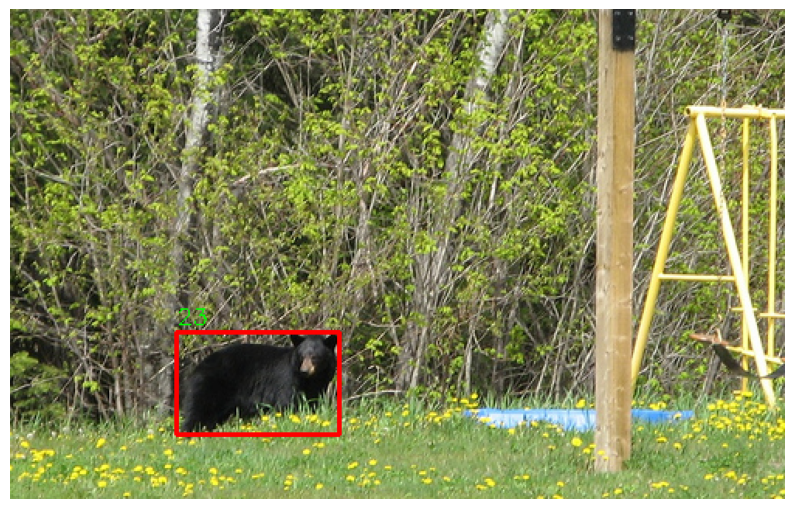

In [14]:
import cv2
import os
import matplotlib.pyplot as plt

def plot_bboxes(image_path, label_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Чтение разметки
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Отрисовка bounding box
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        
        # Конвертация из нормализованных координат в пиксельные
        x_center *= w
        y_center *= h
        width *= w
        height *= h
        
        # Расчет координат углов
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)
        
        # Отрисовка прямоугольника
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Пример использования:
image_path = "C:/Users/KosimiK/AI_PROJECTS/fisheye_project/datasets/coco/train2017/000000003481.jpg"
label_path = "C:/Users/KosimiK/AI_PROJECTS/fisheye_project/datasets/coco/labels/train2017/000000003481.txt"
plot_bboxes(image_path, label_path)

In [48]:
import os
import json
import cv2
import random
from tqdm import tqdm
from pycocotools.coco import COCO
from augmentation import apply_fisheye, apply_fisheye_to_bbox

# Настройки
DATA_DIR = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco"
OUTPUT_BASE = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets"
os.makedirs(OUTPUT_BASE, exist_ok=True)

# Проверка существования путей
print(f"Проверка существования train2017: {os.path.exists(os.path.join(DATA_DIR, 'train2017'))}")
print(f"Проверка существования val2017: {os.path.exists(os.path.join(DATA_DIR, 'val2017'))}")

# Загрузка COCO
train_coco = COCO(os.path.join(DATA_DIR, "annotations/instances_train2017.json"))
val_coco = COCO(os.path.join(DATA_DIR, "annotations/instances_val2017.json"))

# Функция для создания датасета с X% fisheye в тренировочных данных
def generate_fisheye_dataset(percent: int, output_dir: str):
    os.makedirs(os.path.join(output_dir, "train2017"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val2017"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels/train2017"), exist_ok=True) 
    os.makedirs(os.path.join(output_dir, "labels/val2017"), exist_ok=True)
    
    # 1. Обработка тренировочных данных
    train_img_ids = train_coco.getImgIds()
    num_fisheye_train = int(len(train_img_ids) * percent / 100)
    fisheye_train_ids = set(random.sample(train_img_ids, num_fisheye_train))
    
    # Создаем новые аннотации для тренировки
    new_train_annotations = []
    
    for img_id in tqdm(train_img_ids, desc=f"Processing train {percent}%"):
        img_info = train_coco.loadImgs(img_id)[0]
        img_path = os.path.join(DATA_DIR, "train2017", img_info["file_name"])
        image = cv2.imread(img_path)
        if image is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            return 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        anns = train_coco.loadAnns(train_coco.getAnnIds(imgIds=img_id))
        
        if img_id in fisheye_train_ids:
            image, params = apply_fisheye(image)
            for ann in anns:
                ann["bbox"] = apply_fisheye_to_bbox(ann["bbox"], (img_info["width"], img_info["height"]), params)
        
        cv2.imwrite(os.path.join(output_dir, "train2017", img_info["file_name"]), 
                   cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        new_train_annotations.extend(anns)
    
    # 2. Обработка валидационных данных (все с fisheye)
    val_img_ids = val_coco.getImgIds()
    new_val_annotations = []
    
    for img_id in tqdm(val_img_ids, desc=f"Processing val {percent}%"):
        img_info = val_coco.loadImgs(img_id)[0]
        img_path = os.path.join(DATA_DIR, "val2017", img_info["file_name"])
        image = cv2.imread(img_path)
        if image is None:
            print(f"Не удалось загрузить изображение: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        anns = val_coco.loadAnns(val_coco.getAnnIds(imgIds=img_id))
        image, params = apply_fisheye(image)
        
        for ann in anns:
            ann["bbox"] = apply_fisheye_to_bbox(ann["bbox"], (img_info["width"], img_info["height"]), params)
        
        cv2.imwrite(os.path.join(output_dir, "val2017", img_info["file_name"]), 
                   cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        new_val_annotations.extend(anns)
    
    # Сохранение аннотаций
    with open(os.path.join(output_dir, "annotations_train.json"), "w") as f:
        json.dump({
            "images": train_coco.dataset["images"],
            "annotations": new_train_annotations,
            "categories": train_coco.dataset["categories"]
        }, f)
    
    with open(os.path.join(output_dir, "annotations_val.json"), "w") as f:
        json.dump({
            "images": val_coco.dataset["images"],
            "annotations": new_val_annotations,
            "categories": val_coco.dataset["categories"]
        }, f)

# Генерация всех датасетов
for percent in [10, 20, 30, 40, 50]:
    output_dir = os.path.join(OUTPUT_BASE, f"coco2017_{percent}percent_fisheye")
    print(f"\nГенерация: {output_dir}")
    generate_fisheye_dataset(percent, output_dir)

Проверка существования train2017: True
Проверка существования val2017: True
loading annotations into memory...
Done (t=31.68s)
creating index...
index created!
loading annotations into memory...
Done (t=1.27s)
creating index...
index created!

Генерация: C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco2017_10percent_fisheye


Processing val 10%: 100%|██████████| 5000/5000 [07:46<00:00, 10.72it/s]



Генерация: C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco2017_20percent_fisheye


Processing val 20%: 100%|██████████| 5000/5000 [06:09<00:00, 13.52it/s]



Генерация: C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco2017_30percent_fisheye


Processing val 30%: 100%|██████████| 5000/5000 [05:42<00:00, 14.62it/s]



Генерация: C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco2017_40percent_fisheye


Processing val 40%: 100%|██████████| 5000/5000 [04:53<00:00, 17.01it/s]



Генерация: C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco2017_50percent_fisheye


Processing val 50%: 100%|██████████| 5000/5000 [04:43<00:00, 17.66it/s]


In [8]:
from pycocotools.coco import COCO
import os

BASE = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets"

def convert_coco_to_yolo(json_path, output_dir):
    coco = COCO(json_path)
    os.makedirs(output_dir, exist_ok=True)

    for img_id in coco.imgs:
        img_info = coco.loadImgs(img_id)[0]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        txt_path = os.path.join(output_dir, img_info['file_name'].replace('.jpg', '.txt'))
        
        with open(txt_path, 'w') as f:
            for ann in annotations:
                # COCO bbox: [x_top_left, y_top_left, width, height]
                # YOLO bbox: [x_center, y_center, width, height] (нормализованные)
                x, y, w, h = ann['bbox']
                x_center = (x + w / 2) / img_info['width']
                y_center = (y + h / 2) / img_info['height']
                w_norm = w / img_info['width']
                h_norm = h / img_info['height']
                
                f.write(f"{ann['category_id']} {x_center} {y_center} {w_norm} {h_norm}\n")

for percent in [10, 20, 30, 40, 50]:
    dataset_dir = os.path.join(BASE, f"coco2017_{percent}percent_fisheye")
    convert_coco_to_yolo(
        os.path.join(dataset_dir, "annotations", "annotations_train.json"),
        os.path.join(dataset_dir, "labels", "train2017")
    )
    

loading annotations into memory...
Done (t=19.76s)
creating index...
index created!
loading annotations into memory...
Done (t=20.68s)
creating index...
index created!
loading annotations into memory...
Done (t=20.45s)
creating index...
index created!
loading annotations into memory...
Done (t=19.82s)
creating index...
index created!
loading annotations into memory...
Done (t=20.01s)
creating index...
index created!


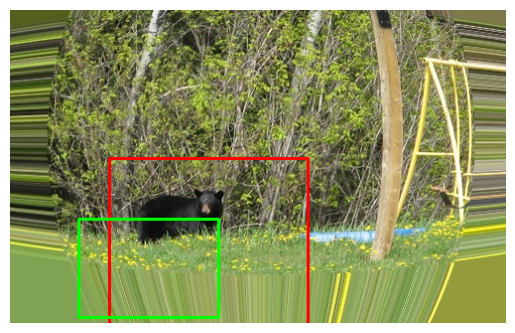

In [13]:
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

def plot_fisheye_bbox(image_path, label_path, original_bbox):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Отрисовка исходного bbox (красный)
    x, y, bw, bh = original_bbox
    cv2.rectangle(image, (int(x), int(y)), (int(x + bw), int(y + bh)), (255, 0, 0), 2)
    
    # Отрисовка скорректированного bbox (зелёный)
    with open(label_path, 'r') as f:
        for line in f:
            cls, xc, yc, w_norm, h_norm = map(float, line.split())
            xc, yc = xc * w, yc * h
            w_px, h_px = w_norm * w, h_norm * h
            x1 = int(xc - w_px / 2)
            y1 = int(yc - h_px / 2)
            cv2.rectangle(image, (x1, y1), (x1 + int(w_px), y1 + int(h_px)), (0, 255, 0), 2)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Пример:
image_path = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco2017_10percent_fisheye\train2017\000000003481.jpg"
label_path = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets\coco2017_10percent_fisheye\labels\train2017\000000003481.txt"
original_bbox = [100, 150, 200, 300]  # Из COCO JSON
plot_fisheye_bbox(image_path, label_path, original_bbox)

In [15]:
from pycocotools.coco import COCO
import os

BASE = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\datasets"

def convert_coco_to_yolo(json_path, output_dir):
    coco = COCO(json_path)
    os.makedirs(output_dir, exist_ok=True)

    for img_id in coco.imgs:
        img_info = coco.loadImgs(img_id)[0]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        txt_path = os.path.join(output_dir, img_info['file_name'].replace('.jpg', '.txt'))
        
        with open(txt_path, 'w') as f:
            for ann in annotations:
                # COCO bbox: [x_top_left, y_top_left, width, height]
                # YOLO bbox: [x_center, y_center, width, height] (нормализованные)
                x, y, w, h = ann['bbox']
                x_center = (x + w / 2) / img_info['width']
                y_center = (y + h / 2) / img_info['height']
                w_norm = w / img_info['width']
                h_norm = h / img_info['height']
                
                f.write(f"{ann['category_id']} {x_center} {y_center} {w_norm} {h_norm}\n")

for percent in [10, 20, 30, 40, 50]:
    dataset_dir = os.path.join(BASE, f"coco2017_{percent}percent_fisheye")
    convert_coco_to_yolo(
        os.path.join(dataset_dir, "annotations", "annotations_val.json"),
        os.path.join(dataset_dir, "labels", "val2017")
    )
    

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
